<a href="https://colab.research.google.com/gist/arkhycat/86e18d5af4f8d0ed66b34eb2de00cd56/mnist_disentangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Loading the data

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

<Figure size 640x480 with 6 Axes>

# Building the network

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.last_layer = F.relu(self.fc1(x))
        x = F.dropout(self.last_layer, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    ll_activations = []
    pred_lst = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            pred_lst.append(pred)
            ll_activations.append(network.last_layer)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return torch.cat(ll_activations), torch.cat(pred_lst)

In [15]:
import numpy as np

merged = []
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    ll_act, pred = test()

    merged = np.hstack((ll_act, pred))

/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1230, Accuracy: 9622/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.400189
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.364464
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.582784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.407425
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.258864
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.453492
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.226545
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.244839
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.445588
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.240626

Test set: Avg. loss: 0.0920, Accuracy: 9715/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144727
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.248434
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.418191
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.218955
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.277363
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.176468
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.301875
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.338

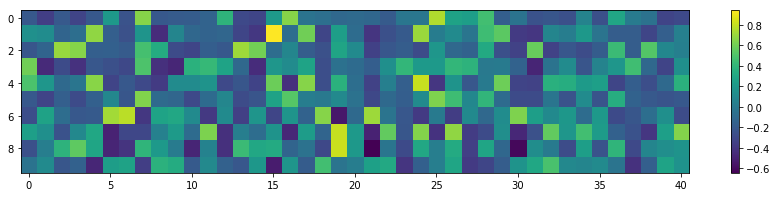

In [22]:
plt.figure(figsize=(15,3))
plt.imshow(np.corrcoef(np.transpose(merged))[-10:, :-10])
plt.colorbar()

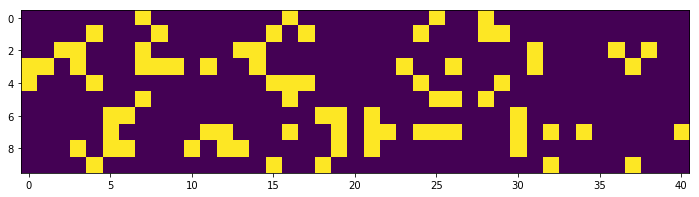

In [57]:
corr_thr = 0.4
plt.figure(figsize=(15,3))
plt.imshow(np.abs(np.corrcoef(np.transpose(merged)))[-10:, :-10]>corr_thr)

In [58]:
corrm = np.corrcoef(np.transpose(merged))[-10:, :-10]
act = [[] for i in range(10)]
for num, neu in zip(*np.where(np.abs(corrm)>corr_thr)):
    act[num].append(neu)
s = list(set([item for sublist in act for item in sublist]))
mapping = {a: i for i, a in enumerate(s)}
act_remapped = [[mapping[i] for i in sublist] for sublist in act]
act_remapped

[[7, 16, 24, 26],
 [4, 8, 15, 17, 23, 26, 27],
 [2, 3, 7, 13, 14, 29, 32, 34],
 [0, 1, 3, 7, 8, 9, 11, 14, 22, 25, 29, 33],
 [0, 4, 15, 16, 17, 23, 27],
 [7, 16, 24, 25, 26],
 [5, 6, 18, 19, 20, 28],
 [5, 11, 12, 16, 19, 20, 21, 23, 24, 25, 28, 30, 31, 35],
 [3, 5, 6, 10, 12, 13, 19, 20, 28],
 [4, 15, 18, 30, 33]]

In [59]:
print("Connections with corr >{} : {}%".format(corr_thr, len(np.where(np.abs(corrm)>corr_thr)[0])/500*100))

Connections with corr >0.4 : 15.4%


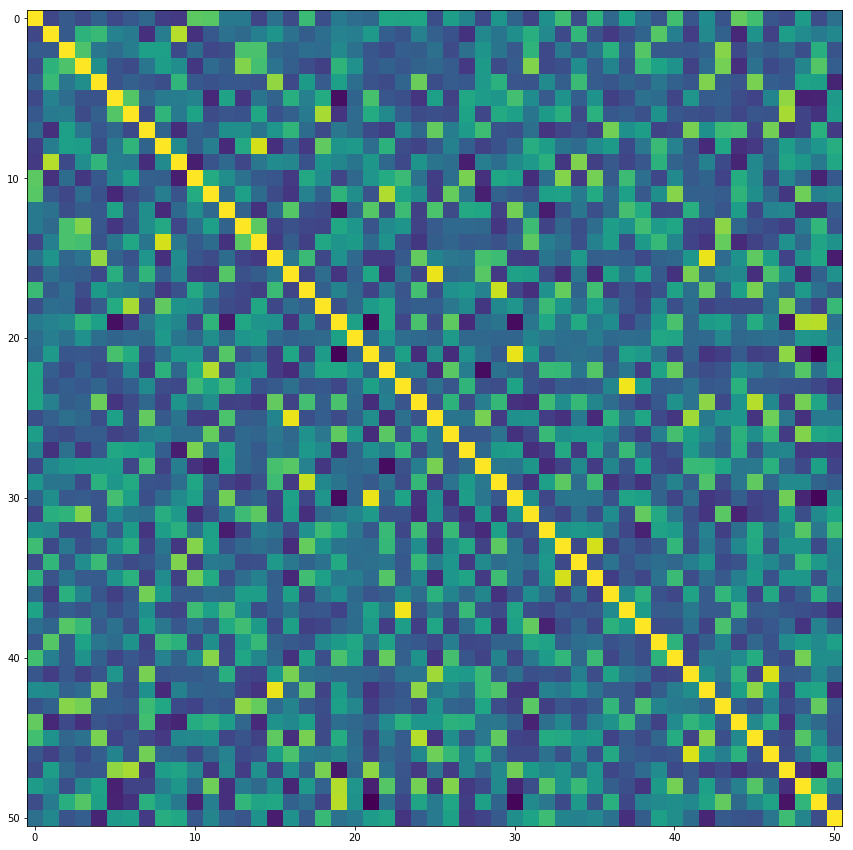

In [60]:
import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(np.corrcoef(np.transpose(merged)))


In [ ]:
!pip install captum

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
dl = DeepLift(net)
input = torch.randn(2, 3, 32, 32, requires_grad=True)
attribution = dl.attribute(input, target=3)